This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. *The objective is to predict based on diagnostic measurements whether a patient has diabetes*.

## Dataset information

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Relevant papers

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). [Using the ADAP learning algorithm to forecast the onset of diabetes mellitus](http://rexa.info/paper/04587c10a7c92baa01948f71f2513d5928fe8e81). *In Proceedings of the Symposium on Computer Applications and Medical Care* (pp. 261--265). IEEE Computer Society Press.

## Data Attributes:

**Pregnancies**: Number of times pregnant

**Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

**BloodPressure**: Diastolic blood pressure (mm Hg)

**SkinThickness**: Triceps skin fold thickness (mm)

**Insulin**: 2-Hour serum insulin (mu U/ml)

**BMI**: Body mass index (weight in kg/(height in m)^2)

**DiabetesPedigreeFunction**: Diabetes pedigree function

**Age**: Age (years)

**Outcome**: Class variable (0 or 1)

[link to example](https://www.kaggle.com/hugues/d/uciml/pima-indians-diabetes-database/basic-ml-best-of-10-classifiers/notebook)

[link to dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

In [9]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#for table-like data and matrices
import numpy as np
import pandas as pd

#Visualisation
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

#Configure Visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
indata = pd.read_csv("./input/diabetes.csv")
indata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print(indata.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [4]:
print('# of rows', len(indata))
print('# of columns', len(indata.columns))
indata.describe()

# of rows 768
# of columns 9


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
#Checking for missing data
print('# of missing data', indata.isnull().any().sum())

# of missing data 0


Pre-Processing and Analysis of the data

In [6]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

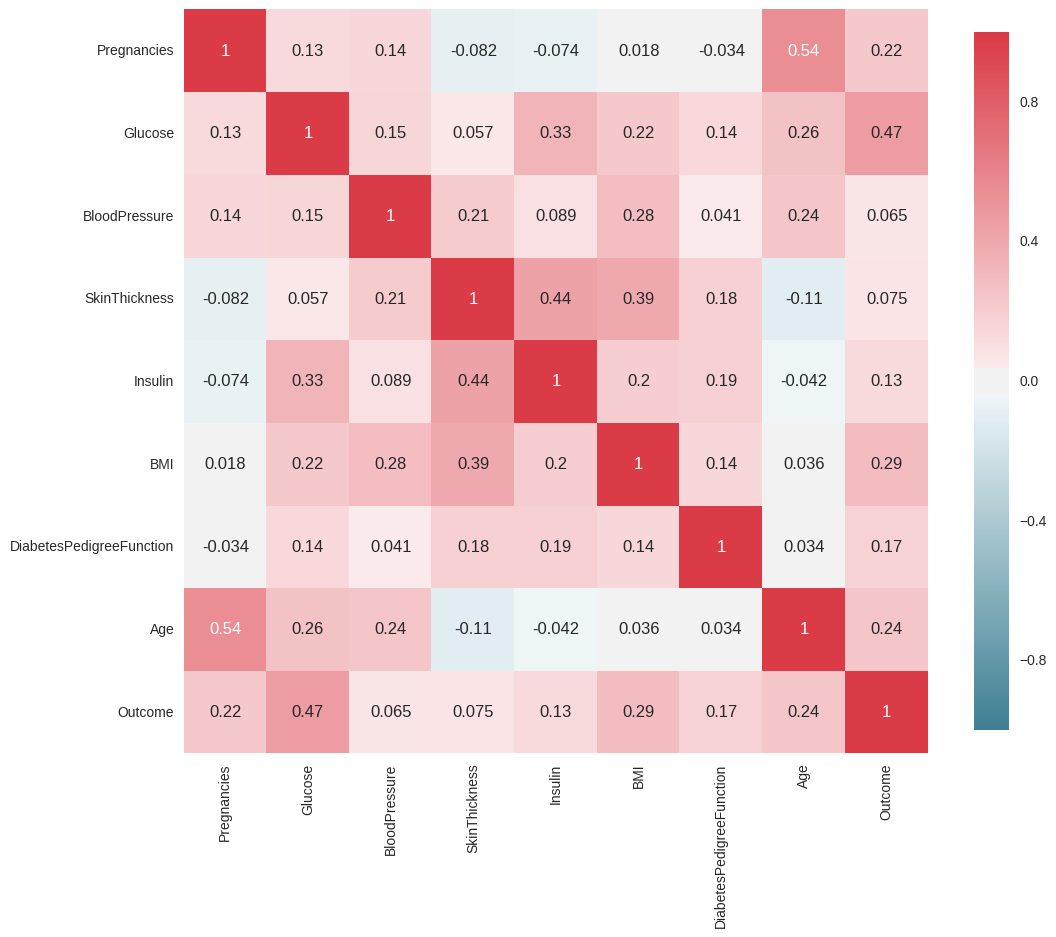

In [10]:
# sns.heatmap(indata.corr())
plot_correlation_map(indata)

In [12]:
describe_more(indata)

,Datatype,Levels,Variable
8,int64,2,Outcome
0,int64,17,Pregnancies
2,int64,47,BloodPressure
3,int64,51,SkinThickness
7,int64,52,Age
1,int64,136,Glucose
4,int64,186,Insulin
5,float64,248,BMI
6,float64,517,DiabetesPedigreeFunction


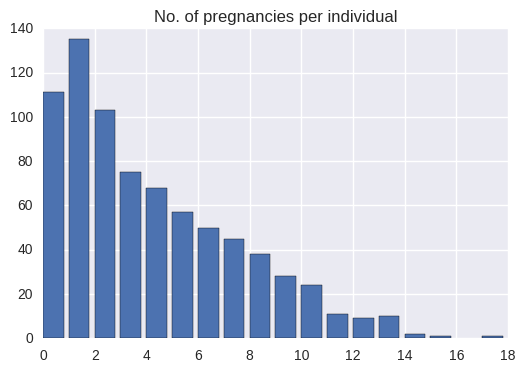

In [43]:
preg_count = indata.groupby('Pregnancies').Pregnancies.count()

values = preg_count.values
indx   = preg_count.index
# print(indx)
# print(values)
# print(sum(values))

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('No. of pregnancies per individual')
plt.xticks(rotation='horizontal')
plt.show()

In [16]:
f = open("/home/grdstu/Documents/Courses/CS7641_ML/Assignments/1/src/input/diabetes.csv")
f.readline()  # skip the header
data = np.loadtxt(f, delimiter = ',')
X = data[:, :-1]
y = data[:, -1]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [18]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Neural Net", "AdaBoost"]

In [19]:
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="rbf"),
    DecisionTreeClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()
]

In [20]:
from sklearn.model_selection import cross_val_score

# iterate over classifiers
results = {}
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    results[name] = scores


In [9]:
for name, scores in results.items():
    print("%20s | Accuracy: %0.2f%% (+/- %0.2f%%)" % (name, 100*scores.mean(), 100*scores.std() * 2))

          Linear SVM | Accuracy: 76.04% (+/- 5.58%)
       Decision Tree | Accuracy: 66.50% (+/- 5.72%)
            AdaBoost | Accuracy: 72.57% (+/- 8.32%)
   Nearest Neighbors | Accuracy: 71.18% (+/- 7.56%)
          Neural Net | Accuracy: 63.70% (+/- 7.89%)
             RBF SVM | Accuracy: 64.24% (+/- 0.44%)


In [17]:
from sklearn.grid_search import GridSearchCV

clf = SVC(kernel="linear")

# prepare a range of values to test
param_grid = [
  {'C': [.01, .1, 1, 10], 'kernel': ['linear']},
 ]

grid = GridSearchCV(estimator=clf, param_grid=param_grid)
grid.fit(X_train, y_train)
print(grid)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [18]:
# summarize the results of the grid search
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 76.39%
Best estimator for parameter C: 0.100000


In [19]:
clf = SVC(kernel="linear", C=0.1)
clf.fit(X_train, y_train)
y_eval = clf.predict(X_test)

In [20]:
acc = sum(y_eval == y_test) / float(len(y_test))
print("Accuracy: %.2f%%" % (100*acc))

Accuracy: 80.21%


In [21]:
clf = SVC(kernel="linear", C=0.1)
scores_final = cross_val_score(clf, X, y, cv=5)

In [22]:
scores_final.mean(), scores_final.std()
print("Final model | Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores_final.mean(), 100*scores_final.std() * 2))

Final model | Accuracy: 76.83% (+/- 4.31%)
